# Targeted Quantization with Quanto

### Getting Started

In [ ]:
# if you are not running the latest version of this tutorial, make sure to install the matching version of pruna
# the following command will install the latest version of pruna
%pip install pruna

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

### 1. Loading a Model

In [ ]:
import torch
from diffusers import DiffusionPipeline

model_id = "black-forest-labs/FLUX.1-dev"
pipe = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path=model_id,
    torch_dtype=torch.bfloat16,
)
pipe = pipe.to(device)

We'll generate an image to compare it to the quantized model later

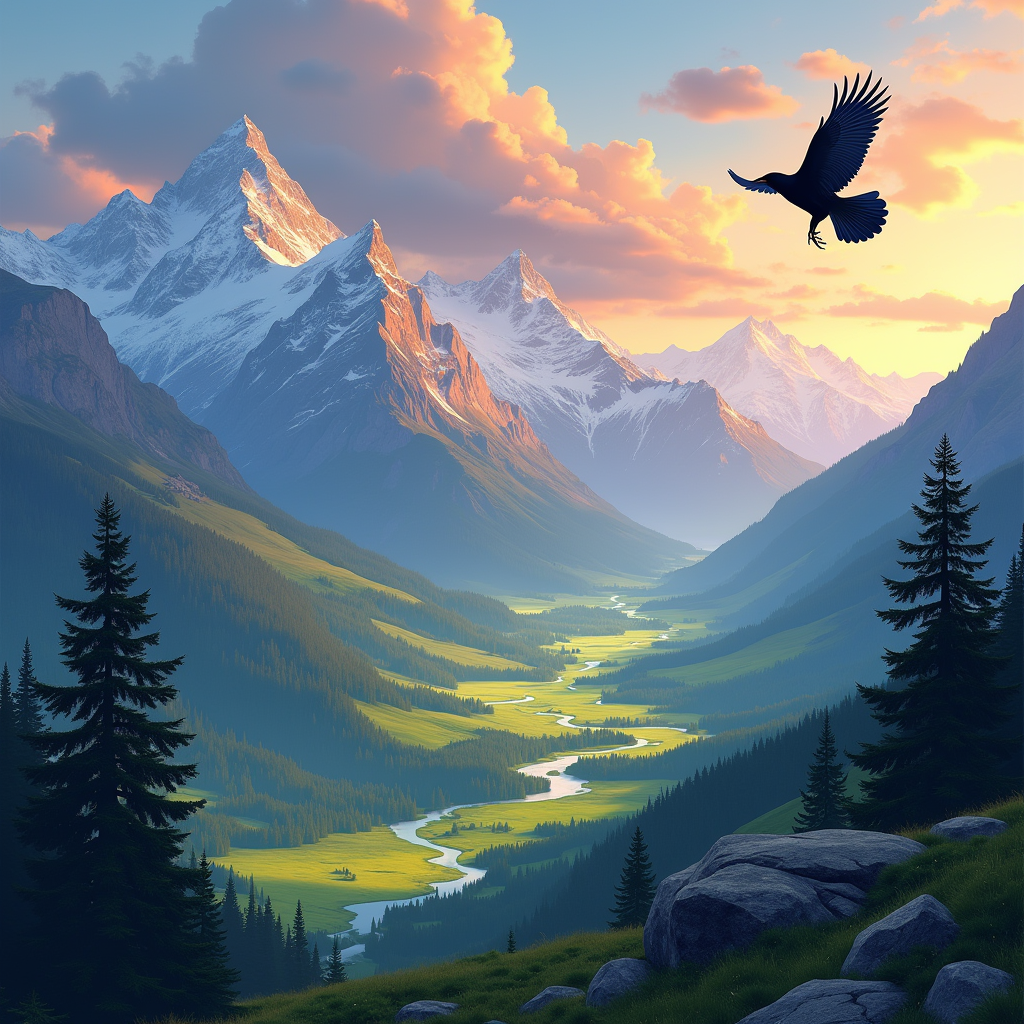

In [ ]:
prompt = "A crow flying over snowy mountains with a vibrant green valley below and warm colors from the sunset. High resolution, realistic style."
img = pipe(prompt, generator=torch.Generator(device=device).manual_seed(42)).images[0]
img.save("original.png")
img

### 2. Define a SmashConfig with Quanto and Smash the Model

A module is select if it matches at least one include pattern and none of the exclude patterns.

In [ ]:
from pruna import SmashConfig, smash

smash_config = SmashConfig()
smash_config["quantizer"] = "quanto"
smash_config["quanto_weight_bits"] = "qint4"
pipe = smash(pipe, smash_config)

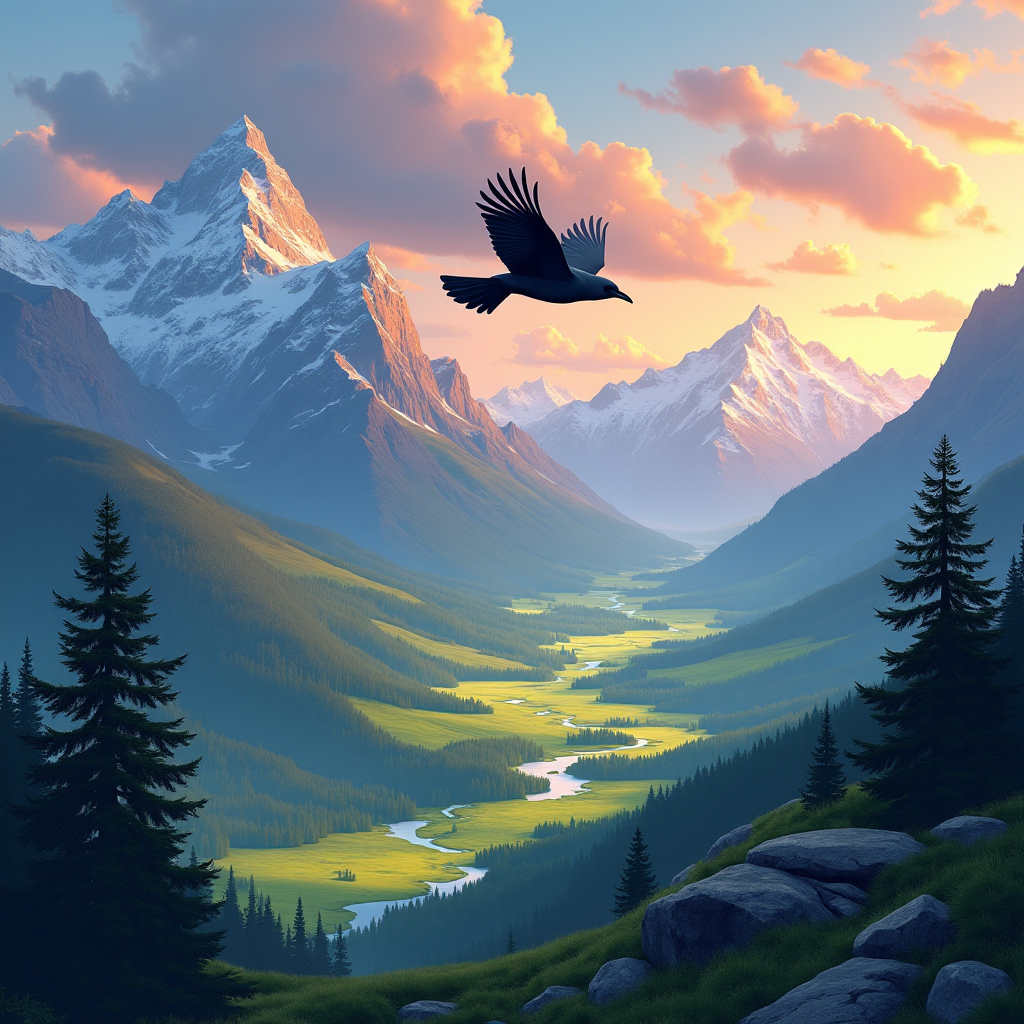

In [ ]:
img = pipe(prompt, generator=torch.Generator(device=device).manual_seed(42)).images[0]
img.save("smashed.png")
img

We're using a 4-bit quantization, which is pretty aggressive with quanto. The quality is still there but the image is different from the original.
To make it closer, we'll exclude sensitive parts of the layer from the quantization.

### 3. Load the Original Model again

First let's clear the first model to free memory.

In [ ]:
from pruna.engine.utils import safe_memory_cleanup

pipe.destroy()
del pipe
safe_memory_cleanup()

Now we can load the original model again.

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path=model_id,
    torch_dtype=torch.bfloat16,
)
pipe = pipe.to(device)

### 4. Smash the Model again with Target Modules

As before, we use 4-bit quantization from Quanto:

In [ ]:
smash_config["quantizer"] = "quanto"
smash_config["quanto_weight_bits"] = "qint4"

Here, we'll avoid quantizing layers related to the embeddings which are sensitive to quantization.

Note that we are applying quantization to fewer parts of the model, which means that the smashed model will need more VRAM than the fully quantized version.
However, the selection below only excludes 0.4% of the parameters, so the overhead should be manageable.

In [ ]:
smash_config["quanto_target_modules"] = {
    "include": ["transformer.*"],  # here we consider any module in the model's unet
    "exclude": ["*embed*"],  # and exclude any module containing "embed" in its path
    # you can add other patterns in the include or exclude lists
}

In [ ]:
pipe = smash(pipe, smash_config)

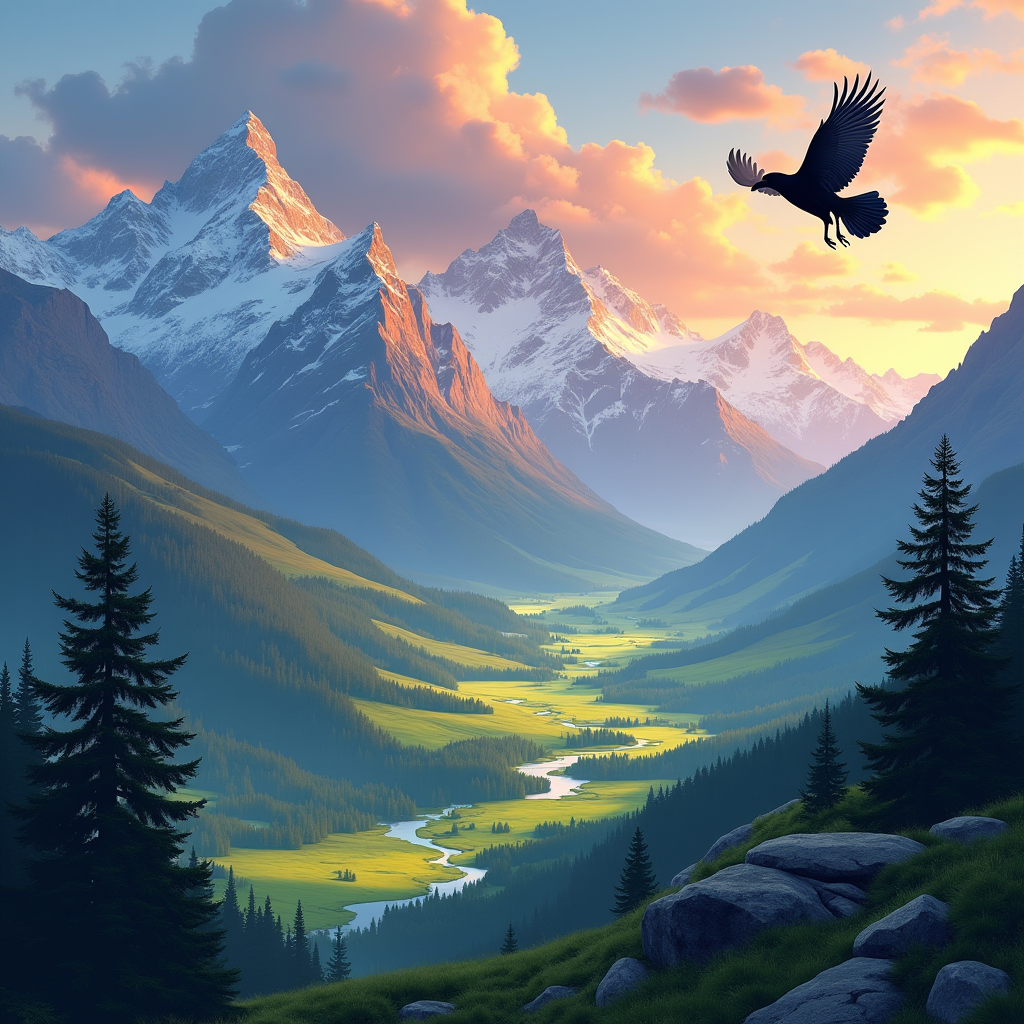

In [ ]:
img = pipe(prompt, generator=torch.Generator(device=device).manual_seed(42)).images[0]
img.save("smashed_target_modules.png")
img

### 5. Compare the Results

Let's load the images we generated and show them side by side.

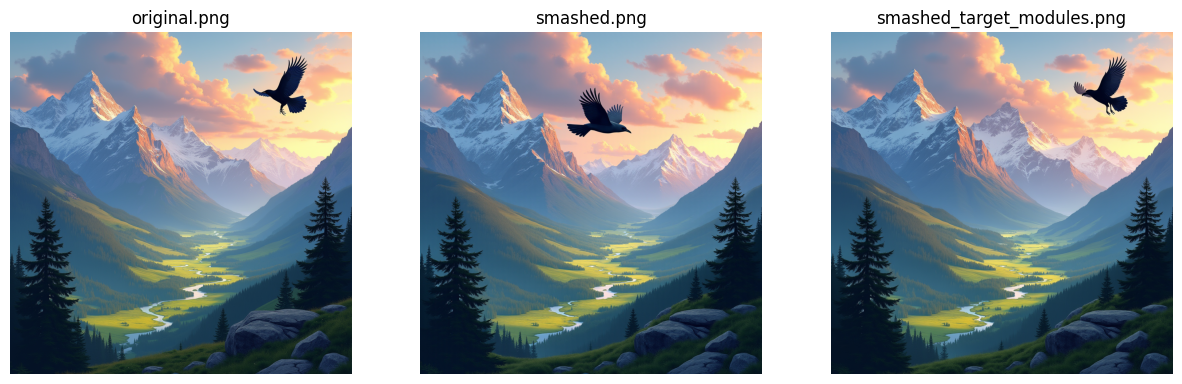

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(["original.png", "smashed.png", "smashed_target_modules.png"]):
    plt.subplot(1, 3, i + 1)
    plt.imshow(plt.imread(img_name))
    plt.title(img_name)
    plt.axis("off")
plt.show()

Much better! Although the fully-quantized model produced an image close to the original, the one with the `target_modules` option is even closer.

### Wrap up

Congratulation! You have successfully smashed a model with a fine-grained control over which modules are quantized.

You can play around excluding different parts of the layer and see their effect on the end result, on the VRAM usage and on the speed of the model.
We plan to add this option to other quantizers so make sure to check if your favorite algorithm already has a `target_modules` hyperparameter!
